## Generative Modeling with Quantum Hardware - Part 1

This is the very first tutorial in a series in which we will discuss generative modelling. In previous series we already discussed how supervised learning works. With these algorithms, the computers learns to classify distinguish data based on some labels we give him. Often we take here the example were the algorithm gets thousands of images of cats and dogs, where we tell him what it sees in the data. At some point it will be able to classify also other cats and dogs. 

But what happens when no labels are available ? This is the field of generative modeling is a sub-domain of machine learning (ML). The goal is to learn from (often unlabeled) data, to generate similar but previously unseed data. Generative Models have undergone a series of breakthroughs in the last decade, with state of the art generative models like GANs (cite) and Diffusion Models (cite) being able to generate breath-taking images like these:\

![StyleGAN and DALL-E 2 generating photorealistic images](images/photorealistic_images.png "StyleGAN and DALL-E 2")

As a very practical example I asked stable diffusion to provide me "a portrait of a female scientist sketching generative models on a white-board". And as a result we obtained the provided images. Feel free to try it for yourself [here](https://colab.research.google.com/drive/1WzKrJh9NeEgin-RTYPtSCb0bt6tb-sir#scrollTo=vF9Q0xKX8gLR).

But what are generative models and what do they have to do with quantum computers?


In this notebook, we will go over an example of an intuitive generatie modeling task which highlights many of the building blocks that can later be replaced with quantum circuits.

In [1]:
# The usual imports
import numpy as np
import matplotlib.pyplot as plt

Just like in any machine learning task, we start out with data. This will be the _training data_ for our machine learning algorithm.

In [2]:
data_samples = np.array(
      [-3.61078109e-01, -1.29291442e-01, -9.82588388e-02, -2.58432923e-01,
       -4.97863965e-01, -4.78795061e-01, -5.10663163e-01,  4.36223299e-02,
       -1.01858250e-02, -5.57657880e-01, -5.61011437e-01, -2.63656495e-01,
       -5.00136079e-01, -6.30125377e-01, -1.12999295e-01, -3.22838879e-01,
       -7.75881873e-01,  1.68190537e-01, -2.69496934e-01, -3.04754810e-01,
       -2.62099948e-01,  1.36922064e-01,  3.93391710e-01, -8.12181958e-01,
       -3.15903057e-01,  1.10533721e-01, -2.50864695e-01,  6.56386891e-02,
       -2.37497275e-01, -6.04398679e-01, -5.32560555e-01, -1.62669444e-01,
       -4.45701188e-01, -1.67952827e-01, -5.07722157e-01, -8.51854037e-02,
       -1.35821066e+00, -3.39440908e-01, -6.41656480e-01, -9.51452941e-01,
       -8.23083293e-01, -5.69844420e-01, -1.04400576e-01, -3.71350420e-01,
       -8.65458568e-01, -2.64222047e-01,  8.06578890e-04, -5.68337779e-01,
       -6.25077227e-01, -1.00012510e+00,  7.59518951e-01,  2.46827712e-01,
        5.70561107e-01,  6.52003162e-01,  6.73384341e-01,  8.04894781e-01,
        6.34541410e-01,  3.63315273e-01,  4.36242632e-01,  3.31473086e-01,
        5.18170902e-01,  6.00943305e-01,  7.09919182e-01,  5.42156544e-01,
        5.96010036e-01,  6.32350524e-01,  5.11792431e-01,  7.26352234e-01,
        5.24889933e-01,  6.33500447e-01,  7.76251971e-01,  7.53647980e-01,
        3.36153030e-01,  8.15441364e-01,  5.57272462e-01,  1.44661947e-01,
        6.16792976e-01,  6.91086153e-01,  6.87286823e-01,  3.98429153e-01,
        1.07054311e+00,  6.24690432e-01,  6.84406406e-01,  7.26905590e-01,
        3.09651946e-01,  7.78085930e-01,  3.60425786e-01,  6.33481589e-01,
        3.17310855e-01,  6.56363955e-01,  6.10979533e-01,  8.08938177e-01,
        7.71336408e-01,  6.11452930e-01,  5.03192825e-01,  5.66868324e-01,
        7.22434360e-01,  5.64687162e-01,  5.11510302e-01,  7.02255988e-01]
)

print(data_samples.shape)

(100,)


Here we have 100 numbers stored in a numpy array. You can think of them as 100 images with one pixel each, or any other kind of data which only has 1 dimension. 
Lets assume that this is data that we collected in the real world, and that there was a process behind the data generation, i.e., there exists a set of rules that produced this data. In more mathematical terms, this dataset $\mathcal{D}\{x_i\}_i$ consists of data samples $x_i, i=1\dots 100$ , and the process that generated the data is characterized by the probablity distribution $p_{data}(x)$. This probability distribution is generally not known, but it is what we are interested in. Because our goal in the context of generative modeling is to build a _model_ of $p_{data}(x)$, which encodes a probability distribution $p_{model}(x)$, and which approximates the true data distribution $p_{model}(x) \approx p_{data}(x)$. We then want to generate new data samples using our model which follow similar rules as the true data, but they are also novel. With such a model, we don't have to go out into the real world to collect all possible data samples from $p_{data}$, we just have to learn the rules behind how the training data $\mathcal{D}\{x_i\}_i$, i.e., the numbers in the above numpy array, were created.

Lets take a first look at the data:

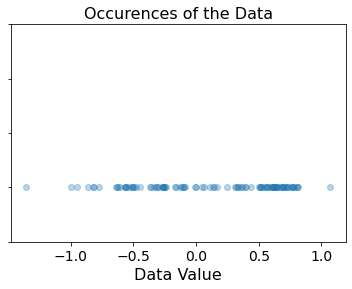

In [3]:
fig, ax = plt.subplots(1,1)

ax.scatter(data_samples, np.zeros(len(data_samples)), alpha=0.3)

ax.set_title("Occurences of the Data", fontsize=16)
ax.set_xlabel("Data Value", fontsize=16)
ax.set_ylim(-0.1, 0.3)
ax.set_yticklabels("")
ax.tick_params(labelsize=14)

plt.show()

This plot shows that the samples in the dataset are mostly in the domain $[-1, 1]$. Lets check out the _density_ of the data samples through a histogram plot:

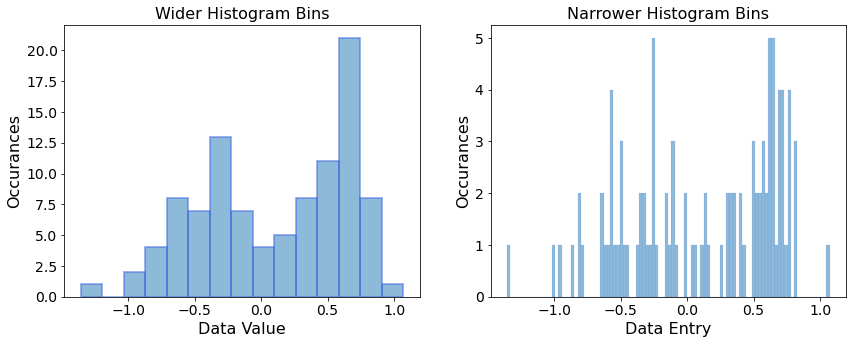

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5))

ax1.hist(data_samples, bins=15, alpha=0.5, edgecolor="royalblue", linewidth=2)
ax2.hist(data_samples, bins=100, alpha=0.5, edgecolor="royalblue", linewidth=0.2)

ax1.set_title("Wider Histogram Bins", fontsize=16)
ax2.set_title("Narrower Histogram Bins", fontsize=16)
ax1.set_xlabel("Data Value", fontsize=16)
ax1.set_ylabel("Occurances", fontsize=16)
ax2.set_xlabel("Data Entry", fontsize=16)
ax2.set_ylabel("Occurances", fontsize=16)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plt.show()

We plot two histgrams with wider and narrower bins, which gives us a sense of coarse and fine trends of the dataset distribution.

Do you see a familiar structure in that data? It may remind you of a gaussian distribution! In this simple example, could it be the case that the data was generated from two gaussians?\
Gaussian distributions are characterized by the parameters $\mu$ (the mean of the gaussian) and $\sigma$ (the width of the gaussian). The _density_ $\rho(x)$ of the distribution around each point $x$ in the data space is then defined as: $$ \rho(x; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac12 (\frac{x-\mu}{\sigma})^2}$$

Lets code it up:

In [5]:
def gaussian(x, mu, sigma):
    return np.exp(-0.5*((x - mu)/sigma)**2.) / (sigma*np.sqrt(2*np.pi))

If we assume that the true underlying distribution is well-approximated by two gaussian distribtions, we might be able to build a _model_, which represents our best guess of the underlying distribution for an optimal set of parameters $\mu$ and $\sigma$. The model density consisting of two gaussians and parameteters $\mu_1,\mu_2,\sigma_1,\sigma_2$ can be defined as
$$ \rho_{model}(x) = \frac{\rho(x; \mu_1, \sigma_1) + \rho(x; \mu_2, \sigma_2)}{2}$$
And in Python:

In [6]:
def model_density_function(x_points, mus, sigmas):
    density_left = gaussian(x_points, mus[0], sigmas[0])
    density_right = gaussian(x_points, mus[1], sigmas[1])
    return (density_left + density_right)/2

Which appear to be reasonable initial guesses for the parameters? To keep it simple, we choose $\mu_1=-0.5, \mu_2 = 0.5$, which are close to the peaks that we observe in the histogram with wider bins. For the width of the gaussians, we remind ourselves that approximately $67\%$ of the area under a gaussian distribution is inside one standard deviation $\sigma$. So how about we choose $\sigma_1=\sigma_2=0.2$. 

In [7]:
model_mus = [-0.3, 0.6]
model_sigmas = [0.2, 0.2]

When we input these values for $\mu$ and $\sigma$ into the model density function, and then scan values of $x$, we get the following plot:

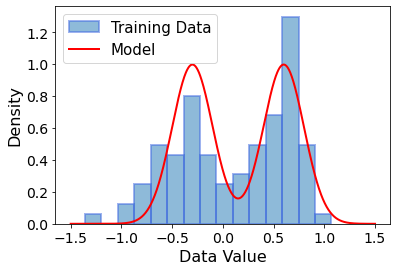

In [8]:
fig, ax = plt.subplots(1,1)

x_points = np.linspace(-1.5, 1.5, 1000)

plt.hist(data_samples, bins=15, density=True, alpha=0.5, edgecolor="royalblue", linewidth=2, label="Training Data")
plt.plot(x_points, model_density_function(x_points, model_mus, model_sigmas), color="red", linewidth=2, label="Model")

plt.legend(fontsize=15)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlabel("Data Value", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

This already looks pretty good! With this, we have implicitly defined the model distribution $p_{model}(x)$! Keep in mind that the model _density_ $\rho_{model}(x)$ and the model _probability distribution_ $p_{model}(x)$ are not the same thing. Instead, $p_{model}(x) \sim \int \rho_{model}(x) \ dx$ represents the area below the curve below the $\rho_{model}(x)$ function, i.e. its integral.


But one crucial step is missing to make the a **generative** model: the _generation_ part. Luckily, we know how to efficiently sample random numbers from gaussian distributions, and the _numpy_ library provides simple functionality for this:

In [9]:
def sample_model_distribution(n_samples, mus, sigmas):    
    n_left_samples = n_samples//2
    n_right_samples = n_samples - n_left_samples
    
    samples = np.append(
        np.random.normal(mus[0], sigmas[0], size=n_left_samples),
        np.random.normal(mus[1], sigmas[1], size=n_right_samples)
    )
    return samples

Collect samples from our model and plot it up!

In [10]:
np.random.seed(42)
generated_samples = sample_model_distribution(1000, model_mus, model_sigmas)

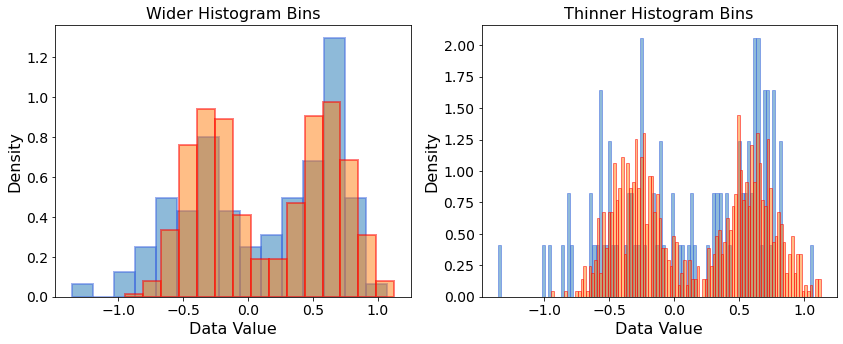

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5))

ax1.hist(data_samples, bins=15, density=True, alpha=0.5, edgecolor="royalblue", linewidth=2, label="Training Data")
ax1.hist(generated_samples, bins=15, density=True, alpha=0.5, edgecolor="red", linewidth=2, label="Generated Data")
ax2.hist(data_samples, bins=100, density=True, alpha=0.5, edgecolor="royalblue", linewidth=1, label="Training Data")
ax2.hist(generated_samples, bins=100, density=True, alpha=0.5, edgecolor="red", linewidth=1, label="Generated Data")

ax1.set_title("Wider Histogram Bins", fontsize=16)
ax2.set_title("Thinner Histogram Bins", fontsize=16)
ax1.set_xlabel("Data Value", fontsize=16)
ax1.set_ylabel("Density", fontsize=16)
ax2.set_xlabel("Data Value", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plt.show()

We now have a full-fledged generative model for 1-dimensional data samples, where we can tune the parameters $\mu_1,\mu_2,\sigma_1,\sigma_2$ and then sample from $p_{model}(x)$. 

## Summary and outlook

Let's recap what we have done so far and how this exemplifies common tasks in generative ML tasks. The moving pieces that we saw were:

- **The dataset**. How does it look like? Here, we had 100 1-dimensional data samples.
- **The model**.  The goal is to learn a model of the true underlying probability distribution of the data, i.e., you want to learn the distribution from which the data itself was sampled from. In our case the highly specialized gaussian distribution.

After plotting a histogram with the data, we made an educated guess that the true underlying distribution of the data, i.e., the distribution that the data itself was sampled from, consists of two gaussian distributions. With reasonable initial parameter guesses, we are now able to generate samples which apparently follow a very similar distributionto the original data samples. But is this machine learning? Not quite. The **learning** part is missing. We have a generative model, but we were only able to guess the underlying structure (i.e., the gaussians), as well as good initial parameters because the task is rather simple.  In later tutorials, we will see how the gaussian model can be substituded by quantum circuits with many more parameters.

In more realistic cases, we won't be able to guess such good initial models. This is why modern ML models are built using up to billions of parameters which are optimized/trained according to a _loss function_. And this is the topic of our [next tutorial](https://). 
